## Tugas 
Buatlah sebuah model K-Means dengan ketentuan,

1. Gunakan data 'Mall_Customers.csv'
2. Tentukan fitur apa yang tepat untuk melakukan clustering (minimal 2)
3. Buatlah model K-Means dengan mempertimbangkan jumlah  yang terbaik.
4. Buatlah  implementasi model SOM untuk segmentasi citra lain

### Persiapan Data

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['OMP_NUM_THREADS'] = '1'
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

mall = pd.read_csv('assets/Mall_Customers.csv')

mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Pemilihan fitur terbaik menggunakna ANOVA

In [2]:
from sklearn.feature_selection import f_classif, SelectKBest

# Data Anda
X = mall[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
y = mall["Gender"]

# Encoding label gender
y = y.map({"Male": 0, "Female": 1})

# Proses seleksi fitur dengan ANOVA
selector = SelectKBest(f_classif, k=2)  # Mengambil 2 fitur terbaik
X_new = selector.fit_transform(X, y)

# Menampilkan skor ANOVA untuk setiap fitur
anova_scores = selector.scores_
feature_names = X.columns
anova_result = pd.DataFrame({"Feature": feature_names, "ANOVA Score": anova_scores})
print(anova_result)


                  Feature  ANOVA Score
0                     Age     0.736286
1      Annual Income (k$)     0.632060
2  Spending Score (1-100)     0.670837


In [3]:
# Label Encode Gender
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

mall["Gender"] = label_encoder.fit_transform(mall["Gender"])

# Seleksi Fitur
X = mall.iloc[:, 3:]
y = mall.iloc[:, 1]

mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


### Scaling Data menggunakan MinMaxScaler

In [4]:
from sklearn.preprocessing import MinMaxScaler
cols = X.columns

ms = MinMaxScaler()

# standarisasi feature
X = ms.fit_transform(X)

X = pd.DataFrame(X, columns=[cols])

X.head()


,Annual Income (k$),Spending Score (1-100)
0,0.000000,0.387755
1,0.000000,0.816327
2,0.008197,0.051020
3,0.008197,0.775510
4,0.016393,0.397959


### Membuat Model K-Means dengan dua kluster


In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto') 

kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto', random_state=0)

In [6]:
# Cek inertia, apabia nilai inertia kecil maka model sudah cukup baik
kmeans.inertia_

14.0859825590406

### Cek kualitas klasifikasi lemah dengan model beserta skor akurasi prediksinya

In [7]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 101 out of 200 samples were correctly labeled.
Accuracy score: 0.51


### Menggunakan Elbow Method dan silhouette untuk cek jumlah n_clusters paling optimal

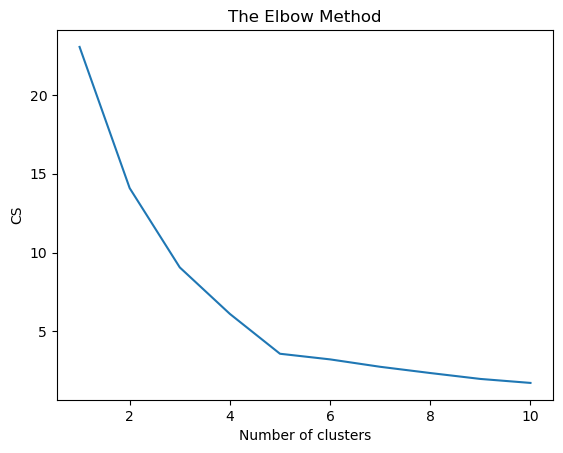

In [8]:
# Elbow Method
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 'auto', random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [9]:
# Cek Nilai SSE setiap k
for idx, sse_val in enumerate(cs, start=1): print(f'k={idx}; SSE={sse_val}')

k=1; SSE=23.040720326039906
k=2; SSE=14.0859825590406
k=3; SSE=9.058985215159455
k=4; SSE=6.110312266413655
k=5; SSE=3.583117905952559
k=6; SSE=3.226303146343746
k=7; SSE=2.7560382036319675
k=8; SSE=2.3606648946421926
k=9; SSE=1.985840284495639
k=10; SSE=1.7333187281815436


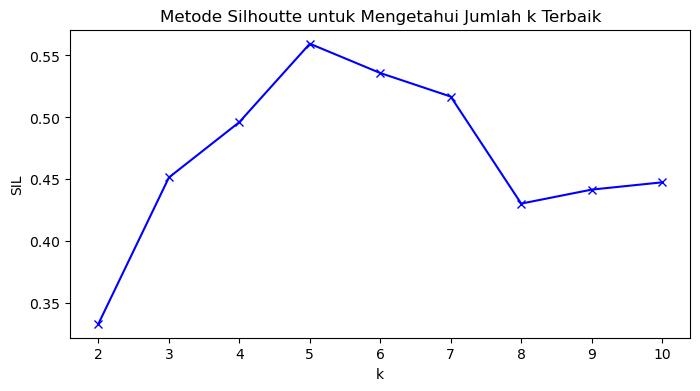

In [10]:
# Silhouette Method
from sklearn.metrics import silhouette_score

sil = []
kmax = 10
K = range(2, kmax+1)

for k in K:
  kmeans = KMeans(n_clusters=k, n_init=10).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric='euclidean'))

plt.figure(figsize=(8, 4))
plt.plot(K, sil, "bx-")
plt.xlabel("k")
plt.ylabel("SIL")
plt.title("Metode Silhoutte untuk Mengetahui Jumlah k Terbaik")
plt.show()

### Analisis
Setelah dilakukan metode elbow dan silhouette untuk mengetahui jumlah k terbaik, ditemukan bahwa k=2 yang paling optimal. Dibuktikan dengan skor SIL yang paling rendah di silhoutte, dan skor inertia tertinggi kedua di elbow method. Penggunaan k=2 juga paling optimal karena memang pada dasarnya labelnya hanya ada dua yaitu Male dan Female, sehingga k=2 adalah yang paling memungkinkan menghasilkan skor inertia atau SSE optimal. 

### Nomor 4 | Implementasi SOM untuk segmentasi citra lain

In [11]:
%pip install minisom

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Fungsi untuk menginisialisasi bobot SOM

In [13]:
def initialize_weights(input_shape, output_shape):
    return np.random.rand(output_shape[0], output_shape[1], input_shape[2])

### Fungsi untuk menghitung jarak antara vektor input dan bobot SOM



In [14]:
def calculate_distance(input_vector, weights):
    return np.linalg.norm(input_vector - weights, axis=2)

### Fungsi untuk menemukan indeks unit pemenang (unit dengan bobot terdekat)



In [15]:
def find_winner_unit_in_image(input_vector, weights):
    distances = calculate_distance(input_vector, weights)
    return np.unravel_index(np.argmin(distances), distances.shape)

### Fungsi untuk memperbarui bobot SOM

In [16]:
def update_weights(input_vector, weights, winner, learning_rate, neighborhood_radius):
    distances = np.linalg.norm(np.indices(
        weights.shape[:2]).T - np.array(winner).reshape(1, -1), axis=2)
    influence = np.exp(-distances / (2 * neighborhood_radius**2))
    weights += learning_rate * \
        influence[:, :, np.newaxis] * (input_vector - weights)

### Fungsi untuk melatih SOM



In [17]:
def train_som(image, num_epochs, initial_learning_rate, initial_neighborhood_radius):
    input_shape = image.shape
    # Ukuran SOM sesuai dengan jumlah saluran warna
    som_shape = (32, 32, input_shape[2])
    weights = initialize_weights(input_shape, som_shape)

    for epoch in range(num_epochs):
        # Update parameter pembelajaran dan radius tetangga
        learning_rate = initial_learning_rate * np.exp(-epoch / num_epochs)
        neighborhood_radius = initial_neighborhood_radius * \
            np.exp(-epoch / num_epochs)
        # Pemrosesan SOM
        for i in range(input_shape[0]):
            for j in range(input_shape[1]):
                input_vector = image[i, j, :]
                winner = find_winner_unit_in_image(input_vector, weights)
                update_weights(input_vector, weights, winner,
                               learning_rate, neighborhood_radius)

    return weights

In [18]:
nihilism = "assets/nietzsche.jpg"
# Normalisasi intensitas piksel menjadi rentang [0, 1]
nothingness = io.imread(nihilism) / 255.0

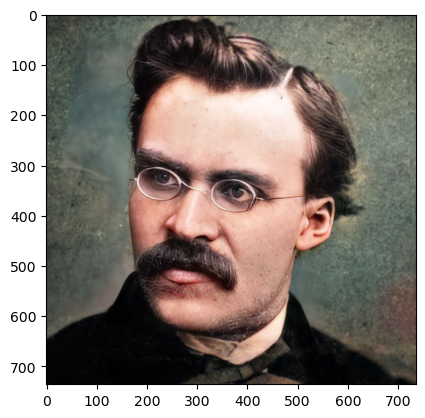

In [19]:
plt.imshow(nothingness)

### Latih SOM

In [20]:
num_epochs = 10
initial_learning_rate = 0.1
initial_neighborhood_radius = 1
trained_weights = train_som(nothingness, num_epochs, initial_learning_rate, initial_neighborhood_radius)

### Visualisasi bobot SOM

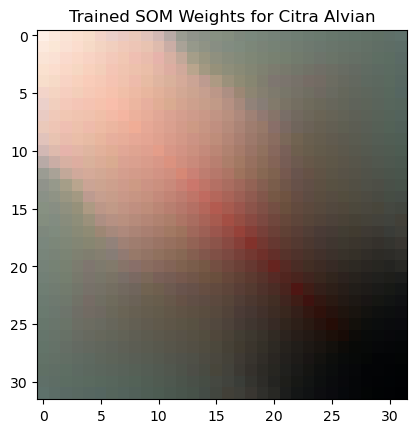

In [21]:
plt.imshow(trained_weights)
plt.title('Trained SOM Weights for Citra Nihil')
plt.show()

### Latih SOM  (initial_neighborhood_radius = 5)

In [22]:
num_epochs = 10
initial_learning_rate = 0.1
initial_neighborhood_radius = 5 # ubah ke 5
trained_weights = train_som(nothingness, num_epochs, initial_learning_rate, initial_neighborhood_radius)

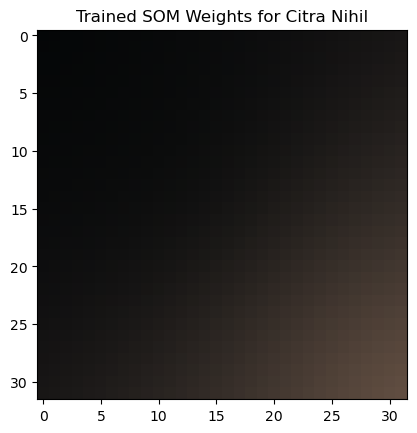

In [23]:
plt.imshow(trained_weights)
plt.title('Trained SOM Weights for Citra Nihil')
plt.show()